In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
from pathlib import Path

src_path = Path('/u/trappist-r0/govorcin/01_OPERA/TROPO/opera_tropo/src')
sys.path.append(str(src_path))

In [4]:
from opera_tropo.config import pge_runconfig
from opera_tropo.log.loggin_setup import setup_logging, log_runtime
from opera_tropo.utils import get_hres_datetime, get_max_memory_usage

In [36]:
from opera_tropo.run import tropo 

opera_tropo.run opera_tropo.log.loggin_setup


In [17]:
cfg = pge_runconfig.RunConfig()
cfg = cfg.from_yaml('opera_tropo/src/opera_tropo/config/default/pge_runconfig.yaml')
cfg.model_dump()

{'input_file': {'input_file_path': '', 'date_fmt': '%Y%m%d'},
 'output_options': {'date_fmt': '%Y%m%dT%H%M%S',
  'creation_time': datetime.datetime(2025, 1, 30, 3, 16, 20, 90810, tzinfo=datetime.timezone.utc),
  'output_heights': [],
  'compression_kwargs': {'compression_flag': True,
   'zlib': True,
   'complevel': 5,
   'shuffle': True},
  'product_version': '0.1'},
 'primary_executable': {'product_type': 'OPERA_TROPO'},
 'product_path_group': {'product_path': PosixPath('output/historical'),
  'scratch_path': PosixPath('scratch/historical'),
  'output_directory': PosixPath('output/historical'),
  'product_version': '0.1'},
 'worker_settings': {'n_workers': 1,
  'threads_per_worker': 2,
  'max_memory': 4,
  'dask_temp_dir': 'tmp',
  'block_shape': (128, 256)},
 'log_file': PosixPath('scratch/historical/log_sas.log')}

In [20]:
cfg.input_file.input_file_path = '/u/trappist-r0/govorcin/01_OPERA/HRES/data/D01010000010100001.subset.zz.nc'
cfg.log_file = '/u/trappist-r0/govorcin/01_OPERA/HRES/data/log_sas.log'
cfg.worker_settings.block_shape = (128, 128)

In [21]:
cfg.model_dump()

{'input_file': {'input_file_path': '/u/trappist-r0/govorcin/01_OPERA/HRES/data/D01010000010100001.subset.zz.nc',
  'date_fmt': '%Y%m%d'},
 'output_options': {'date_fmt': '%Y%m%dT%H%M%S',
  'creation_time': datetime.datetime(2025, 1, 30, 3, 16, 20, 90810, tzinfo=datetime.timezone.utc),
  'output_heights': [],
  'compression_kwargs': {'compression_flag': True,
   'zlib': True,
   'complevel': 5,
   'shuffle': True},
  'product_version': '0.1'},
 'primary_executable': {'product_type': 'OPERA_TROPO'},
 'product_path_group': {'product_path': PosixPath('output/historical'),
  'scratch_path': PosixPath('scratch/historical'),
  'output_directory': PosixPath('output/historical'),
  'product_version': '0.1'},
 'worker_settings': {'n_workers': 1,
  'threads_per_worker': 2,
  'max_memory': 4,
  'dask_temp_dir': 'tmp',
  'block_shape': (128, 128)},
 'log_file': '/u/trappist-r0/govorcin/01_OPERA/HRES/data/log_sas.log'}

In [22]:
setup_logging(logger_name="opera_tropo", debug=False, filename=cfg.log_file)
setup_logging(logger_name="RAiDER", filename=cfg.log_file)  # not sure if this works, does not pick logging from RAIDER

/u/trappist-r0/govorcin/01_OPERA/HRES/data/log_sas.log
/u/trappist-r0/govorcin/01_OPERA/HRES/data/log_sas.log


In [26]:
print(cfg.to_workflow().work_directory),
cfg.to_workflow().work_directory.mkdir(exist_ok=True, parents=True)

/u/trappist-r0/govorcin/01_OPERA/TROPO/scratch/historical


In [28]:
workflow_cfg = cfg.to_workflow()

In [31]:
hres_date, hres_hour = get_hres_datetime(workflow_cfg.input_options.input_file_path)
output_filename = workflow_cfg.output_options.get_output_filename(hres_date, hres_hour)
output_filename

'OPERA_L4_TROPO_GLOBAL_20190101T000000Z_20250130T031620Z_HRES_0.1_v0.1.nc'

In [37]:
tropo(file_path = workflow_cfg.input_options.input_file_path,
            output_file = Path(workflow_cfg.work_directory) / output_filename,
            out_heights = workflow_cfg.output_options.output_heights,
            lat_chunk_size = workflow_cfg.worker_settings.block_shape[0],
            lon_chunk_size = workflow_cfg.worker_settings.block_shape[1],
            num_workers = workflow_cfg.worker_settings.n_workers,
            num_threads = workflow_cfg.worker_settings.threads_per_worker,
            max_memory = workflow_cfg.worker_settings.max_memory,
            compression_options = workflow_cfg.output_options.compression_kwargs,
            temp_dir = workflow_cfg.worker_settings.dask_temp_dir
        )

[INFO|run|L71] 2025-01-29T19:20:53-0800: Calculating TROPO delay
/u/trappist-r0/govorcin/src/tools/conda/envs/opera_tropo/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44835 instead
  warnings.warn(
[INFO|run|L92] 2025-01-29T19:20:54-0800: Dask server link: http://127.0.0.1:44835/status
[INFO|run|L104] 2025-01-29T19:20:54-0800: Rechunking /u/trappist-r0/govorcin/01_OPERA/HRES/data/D01010000010100001.subset.zz.nc
[INFO|run|L140] 2025-01-29T19:20:57-0800: Estimating ZTD delay
[INFO|run|L146] 2025-01-29T19:25:07-0800: ZTD calculation took 250.11 seconds.
[INFO|run|L166] 2025-01-29T19:25:32-0800: Saving and Compressing took 25.38 seconds.


In [38]:
import xarray as xr
from matplotlib import pyplot as plt

In [40]:
# Verify result
ds = xr.open_dataset(Path(workflow_cfg.work_directory) / output_filename)
ds

<xarray.Dataset> Size: 1GB
Dimensions:            (time: 1, longitude: 1494, latitude: 768, height: 145)
Coordinates:
  * time               (time) datetime64[ns] 8B 2019-01-01
  * longitude          (longitude) float32 6kB 8.016 8.086 8.156 ... 112.9 113.0
  * latitude           (latitude) float32 3kB 71.95 71.88 71.81 ... 18.1 18.03
  * height             (height) float32 580B -500.0 -300.0 ... 8.03e+04
Data variables:
    spatial_ref        int64 8B ...
    wet_delay          (time, latitude, longitude, height) float32 665MB ...
    hydrostatic_delay  (time, latitude, longitude, height) float32 665MB ...
Attributes:
    Conventions:       CF-1.7
    title:             OPERA Zenith Troposphere Delay
    institution:       Jet Propulsion Laboratory (JPL)
    source:            ECMWF, HRES model
    source_url:        https://www.ecmwf.int/en/forecasts/datasets/set-i
    history:           2025-01-30 03:19:33.189214+00:00
    references:        https://raider.readthedocs.io/en/latest/
    description:       OPERA One-way Tropospheric Zenith Delay, interpolate w...
    software:          RAiDER
    software_version:  0.5.3
    reference_time:    2019-01-01 00:00:00

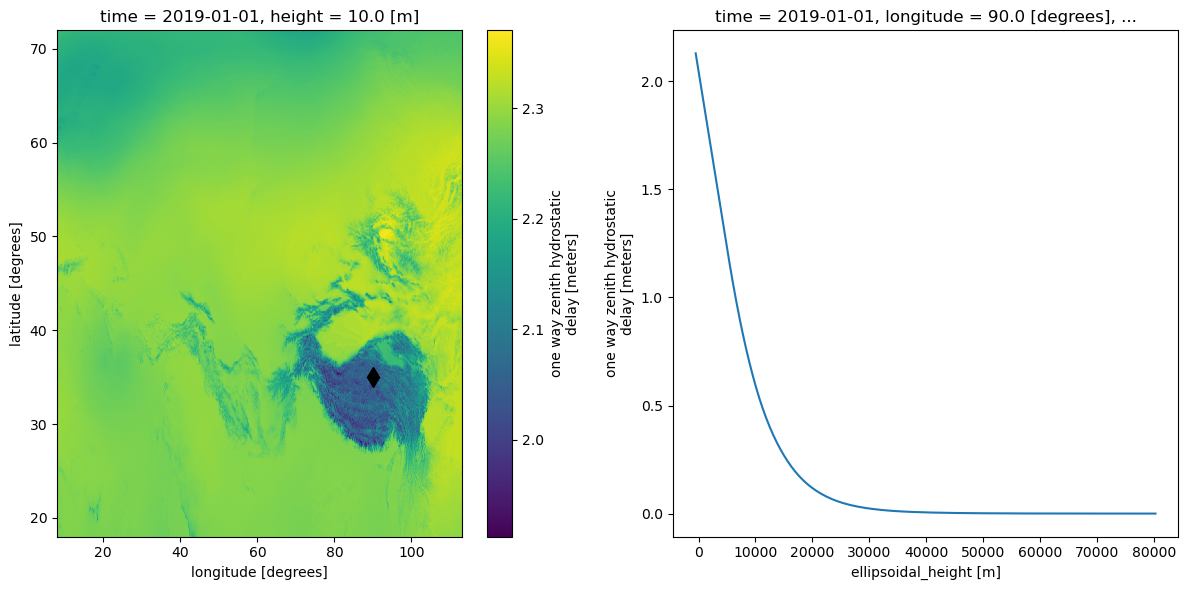

In [46]:
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(12,6))
ds.hydrostatic_delay.isel(time=0, height=8).plot.imshow(ax=ax[0])
ax[0].plot(90, 35, 'kd', ms=10)
ds.hydrostatic_delay.isel(time=0).sel(longitude=90, latitude=35, method='nearest').plot(ax=ax[1])
plt.tight_layout()

In [47]:
ds.close()

In [50]:
get_max_memory_usage(units="GB")

6.349676